<a href="https://colab.research.google.com/github/pndang/Everything-PyTorch/blob/master/SimpleRNN_Sine_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

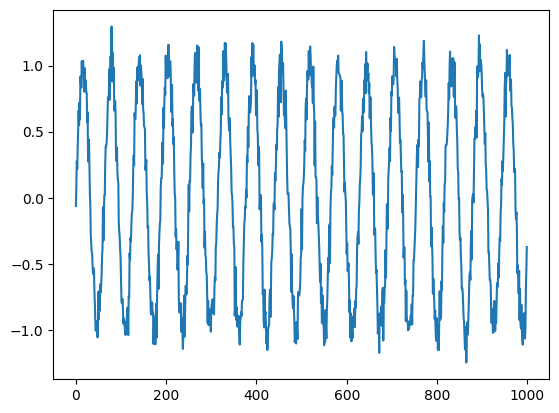

In [201]:
# Make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# Plot
plt.plot(series)
plt.show()

In [202]:
# uild dataset, use T past values to predict the next value

T = 10
X = []
Y = []
for t in range(len(series) - T):
  X.append(series[t:t+T])
  Y.append(series[t+T])

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [203]:
X[:3]

array([[[-0.06238976],
        [ 0.08289613],
        [ 0.27728749],
        [ 0.21888596],
        [ 0.38291786],
        [ 0.4970407 ],
        [ 0.65838739],
        [ 0.55120553],
        [ 0.71981721],
        [ 0.59117338]],

       [[ 0.08289613],
        [ 0.27728749],
        [ 0.21888596],
        [ 0.38291786],
        [ 0.4970407 ],
        [ 0.65838739],
        [ 0.55120553],
        [ 0.71981721],
        [ 0.59117338],
        [ 0.91689438]],

       [[ 0.27728749],
        [ 0.21888596],
        [ 0.38291786],
        [ 0.4970407 ],
        [ 0.65838739],
        [ 0.55120553],
        [ 0.71981721],
        [ 0.59117338],
        [ 0.91689438],
        [ 0.86373319]]])

In [204]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [205]:
## Define simple RNN

class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # Note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True
    )

    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # Initial hidden state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # Get RNN unit output
    # out is of size (N, T, M)
    # 2nd return val is hidden state at each hidden layer (no need now)
    # 1st return val is hidden state at each time instance
    out, _ = self.rnn(X, h0)

    # We only want h(t) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])

    return out

In [206]:
# Instantiate model

model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [207]:
# Loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [208]:
# Make inputs and targets

X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [209]:
# Move data to GPU

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [210]:
# Training

def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for ite in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward and optimize
    loss.backward()
    optimizer.step()

    # save losses
    train_losses[ite] = loss.item()

    # test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[ite] = test_loss.item()

    if (ite + 1) % 5 == 0:
      print(f'Epoch {ite+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [211]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.1980, Test Loss: 0.0623
Epoch 10/200, Train Loss: 0.2468, Test Loss: 0.2452
Epoch 15/200, Train Loss: 0.1695, Test Loss: 0.1459
Epoch 20/200, Train Loss: 0.0629, Test Loss: 0.0559
Epoch 25/200, Train Loss: 0.0448, Test Loss: 0.0488
Epoch 30/200, Train Loss: 0.0445, Test Loss: 0.0401
Epoch 35/200, Train Loss: 0.0338, Test Loss: 0.0334
Epoch 40/200, Train Loss: 0.0306, Test Loss: 0.0288
Epoch 45/200, Train Loss: 0.0288, Test Loss: 0.0286
Epoch 50/200, Train Loss: 0.0285, Test Loss: 0.0276
Epoch 55/200, Train Loss: 0.0280, Test Loss: 0.0274
Epoch 60/200, Train Loss: 0.0276, Test Loss: 0.0268
Epoch 65/200, Train Loss: 0.0272, Test Loss: 0.0266
Epoch 70/200, Train Loss: 0.0268, Test Loss: 0.0263
Epoch 75/200, Train Loss: 0.0266, Test Loss: 0.0262
Epoch 80/200, Train Loss: 0.0263, Test Loss: 0.0260
Epoch 85/200, Train Loss: 0.0262, Test Loss: 0.0258
Epoch 90/200, Train Loss: 0.0260, Test Loss: 0.0257
Epoch 95/200, Train Loss: 0.0258, Test Loss: 0.0256
Epoch 100/200

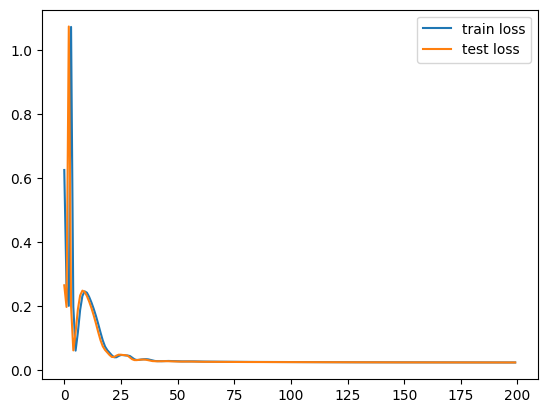

In [212]:
# Plot the train loss and test loss per iteration

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [213]:
# "wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_preds = []

# index of first validation input
i = 0

while len(validation_preds) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  validation_preds.append(p)

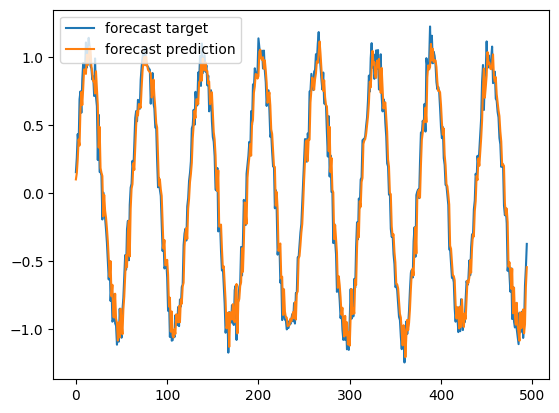

In [214]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_preds, label='forecast prediction')
plt.legend()

In [215]:
# forecast future values (use only self-predictions for making future preds)

validation_target = Y[-N//2:]
validation_preds = []

# last train input
# # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_preds) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar

  validation_preds.append(p[0,0].item())

  # new input
  last_x = torch.cat((last_x[1:], p[0]))


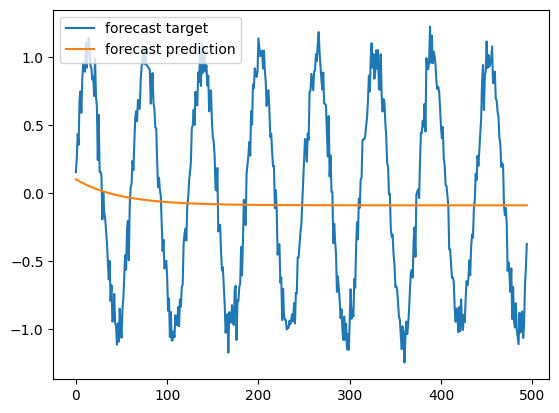

In [216]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_preds, label='forecast prediction')
plt.legend()

--> RNN might be "overkill" for our task of predicting sine wave (Overparameterized)